In [79]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

plt.style.use('/Users/matt/workspace/style.mplstyle')

In [2]:
def kpa_to_psi(kpa):
    return kpa*0.1456038

def c_to_f(c):
    return c*1.8+32

# Load data

In [3]:
df = pd.read_csv('./vir/session_20230720_103040_vir_south_v3.csv')

In [4]:
df.columns.values

array(['timestamp', 'fragment_id', 'lap_number', 'elapsed_time',
       'distance_traveled', 'accuracy', 'altitude', 'bearing',
       'device_battery_level', 'device_update_rate', 'fix_type',
       'latitude', 'longitude', 'satellites', 'speed', 'combined_acc',
       'device_update_rate.1', 'lateral_acc', 'lean_angle',
       'longitudinal_acc', 'speed.1', 'accelerator_pos', 'brake_pos',
       'coolant_temp', 'engine_oil_pressure', 'engine_oil_temp',
       'lateral_acc.1', 'rpm', 'speed.2', 'steering_angle',
       'device_update_rate.2', 'x_acc', 'y_acc', 'z_acc',
       'device_update_rate.3', 'x_rate_of_rotation', 'y_rate_of_rotation',
       'z_rate_of_rotation'], dtype=object)

In [5]:
df = df.dropna(subset=['engine_oil_pressure'])
df['engine_psi'] = df.apply(lambda x: kpa_to_psi(x['engine_oil_pressure']), axis=1)
df['log_engine_psi'] = np.log(df['engine_psi'])
df['engine_oil_temp_f'] = df.apply(lambda x: c_to_f(x['engine_oil_temp']), axis=1)

In [60]:
df['lap_number'].unique()

array([1, 2, 3, 4, 5, 6])

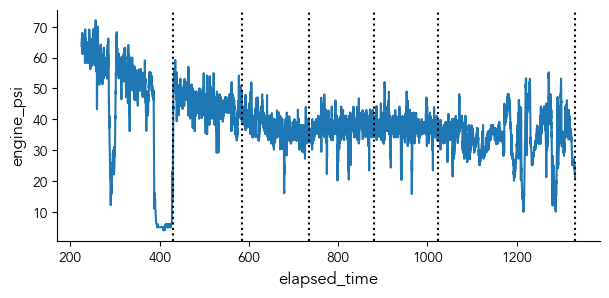

In [62]:
fig, ax = plt.subplots(figsize=(7,3))
sns.lineplot(x = 'elapsed_time', y = 'engine_psi', data = df)
lap_start = []
for idx, lap in enumerate(df['lap_number'].unique()):
    t1 = df.loc[df['lap_number'] == lap, 'elapsed_time'].max()
    ax.axvline(x=t1, ls = ':', color='k')
pass

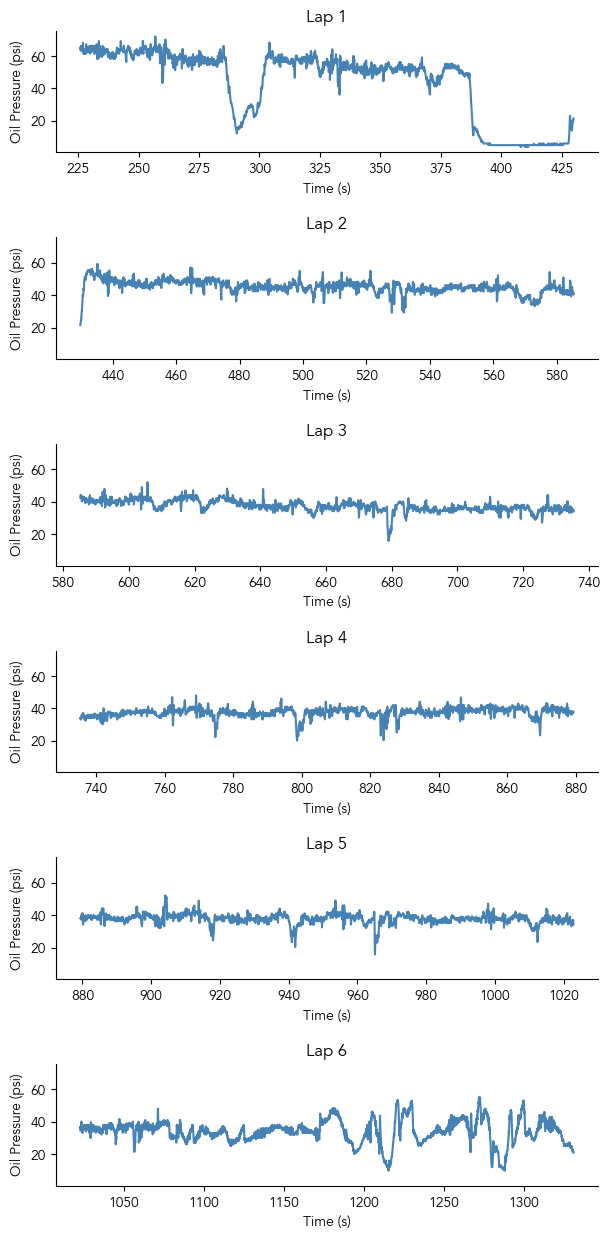

In [64]:
df = df.dropna(subset=['lap_number'])
df['lap_number'] = df['lap_number'].astype(int)

fig, ax = plt.subplots(6,1,figsize=(7,15),sharey=True)
axl = ax.flatten()

for idx, lap in enumerate(df['lap_number'].unique()):
    lap_data = df.loc[df['lap_number'] ==  lap]
    avg_temp = lap_data.head(25*100)['engine_oil_temp_f'].mean()
    a = axl[idx]
    sns.lineplot(ax = a, x = 'elapsed_time', y = 'engine_psi', data = df.loc[df['lap_number']==lap], color='steelblue')
    title = f"""Lap {lap}"""
    #Engine oil temp: {avg_temp:.2f} (first 100s)
    #"""
    a.set_title(title)
    a.set_xlabel('Time (s)', fontsize=10)
    a.set_ylabel('Oil Pressure (psi)', fontsize=10)
fig.subplots_adjust(hspace=0.7)
fig.savefig(f'./vir/figures/oil_pressure_by_lap.png', bbox_inches='tight', facecolor='w')
pass

# Set lap

In [8]:
LAP = 4

In [9]:
test_data = df.loc[df['lap_number'] == LAP].copy()

In [10]:
test_results = adfuller(test_data["engine_psi"])
test_results

(-8.126150039689781,
 1.1217932503571448e-12,
 19,
 8622,
 {'1%': -3.431108669444282,
  '5%': -2.8618752808638335,
  '10%': -2.5669484650654697},
 332.61887388378636)

In [45]:
df.loc[df['lap_number'] ==4, 'elapsed_time'].min()

735.3752

In [50]:
p1 = df.loc[(df['lap_number']==1) & (df['elapsed_time'] <255), 'engine_psi'].mean()
print(p1)

62.771276283025145


In [51]:
p2 = df.loc[(df['lap_number']==LAP) & (df['elapsed_time'] <765), 'engine_psi'].mean()
print(p2)

36.62360831857633


In [53]:
p1-p2

26.147667964448814

In [75]:
#test_data["diff_1"] = test_data["engine_psi"].diff(periods=38)
test_data['engine_psi_adj'] = test_data['engine_psi'] + 26.15

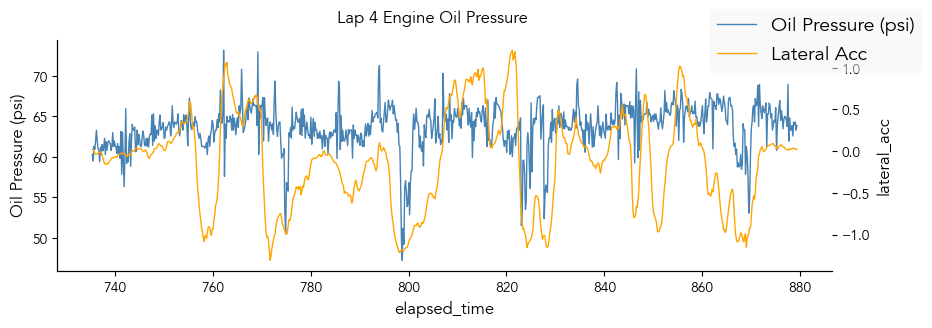

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10,3), sharex=True)

plot_data = test_data[::10]

psi_rate=100

a = ax#axl[0]
a2 = a.twinx()
sns.lineplot(ax = a, x = 'elapsed_time', y = 'engine_psi_adj', data = plot_data, color='steelblue',
             lw=1, label = 'Oil Pressure (psi)', legend=False)
sns.lineplot(ax = a2, x = 'elapsed_time', y = 'lateral_acc', data = plot_data, color='orange',
             lw=1, label='Lateral Acc', legend=False)
# a.plot(plot_data['elapsed_time'].values,
#        plot_data['rpm'].values/psi_rate, color = 'k', ls =':',
#        alpha=0.8, label='10psi/1000rpm')
a.set_ylabel('Oil Pressure (psi)')

fig.legend()
fig.suptitle(f'Lap {LAP} Engine Oil Pressure')
fig.savefig(f'./vir/figures/lap_{LAP}_oil_pressure_latacc.png', bbox_inches='tight', facecolor='w')
pass

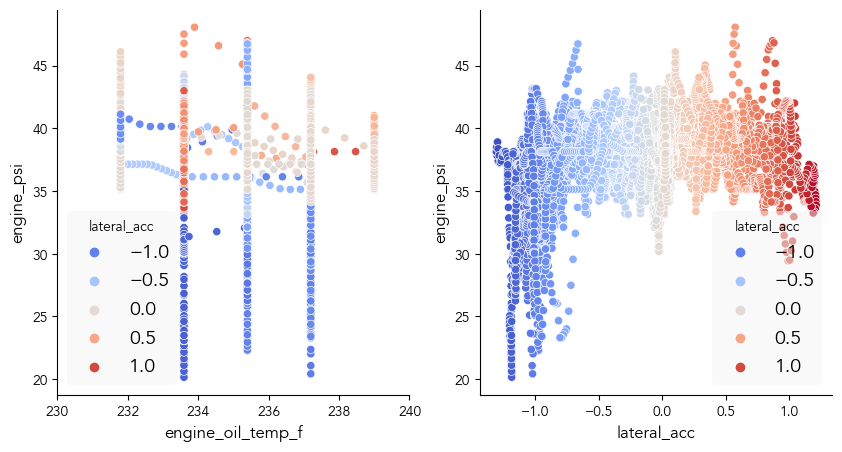

In [167]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
axl = ax.flatten()

a = axl[0]
sns.scatterplot(ax = a, x = 'engine_oil_temp_f', y = 'engine_psi',
               data = test_data, hue = 'lateral_acc', palette='coolwarm')
a.set_xlim([230,240])

a = axl[1]
sns.scatterplot(ax = a, x = 'lateral_acc', y = 'engine_psi',
                data = test_data, hue = 'lateral_acc', palette='coolwarm')
#x = np.arange(4000,7501)
#y = x/100
#a.plot(x,y)
fig.savefig('./vir/figures/lap_4_oil_psi_2scatter.png',bbox_inches='tight', facecolor='w')
pass

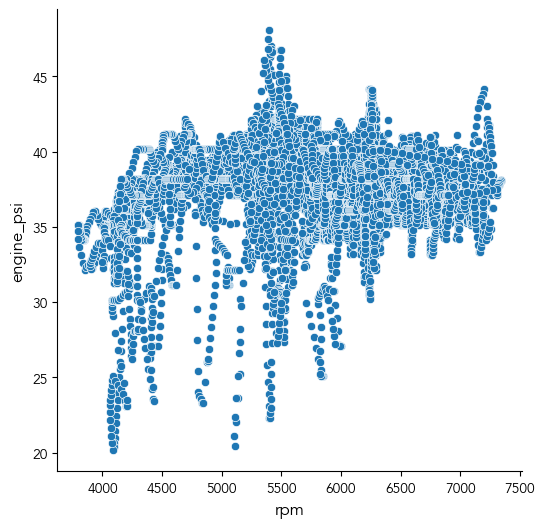

In [146]:
sns.scatterplot(x = 'rpm', y = 'engine_psi', data = test_data)
pass

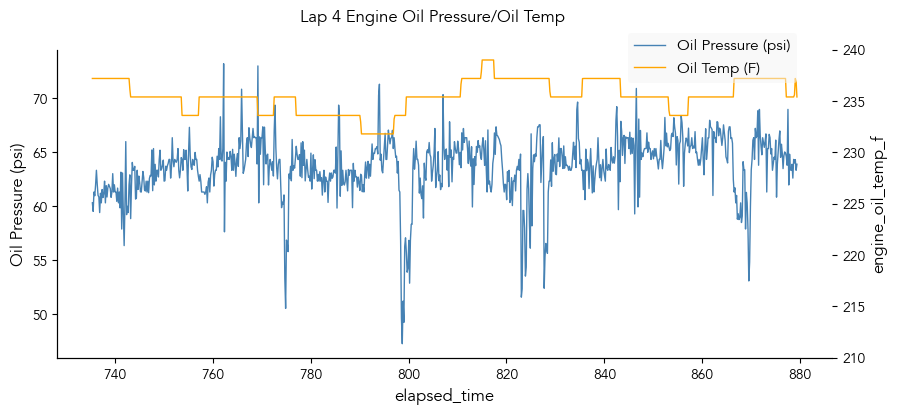

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=True)

plot_data = test_data[::10]

psi_rate=100

a = ax#axl[0]
a2 = a.twinx()
sns.lineplot(ax = a, x = 'elapsed_time', y = 'engine_psi_adj', data = plot_data, color='steelblue',
             lw=1, label = 'Oil Pressure (psi)', legend=False)
sns.lineplot(ax = a2, x = 'elapsed_time', y = 'engine_oil_temp_f', data = plot_data, color='orange',
             lw=1, label='Oil Temp (F)', legend=False)
# a.plot(plot_data['elapsed_time'].values,
#        plot_data['rpm'].values/psi_rate, color = 'k', ls =':',
#        alpha=0.8, label='10psi/1000rpm')
a.set_ylabel('Oil Pressure (psi)')
a2.set_ylim([210,240])

fig.legend(loc=(0.7,0.8), fontsize=11)
fig.suptitle(f'Lap {LAP} Engine Oil Pressure/Oil Temp')
fig.savefig(f'./vir/figures/lap_{LAP}_oil_pressure_oil_temp.png', bbox_inches='tight', facecolor='w')
pass

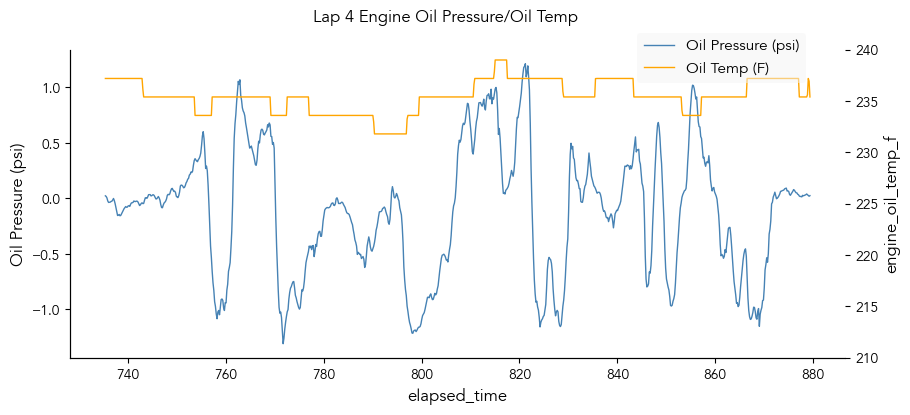

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=True)

plot_data = test_data[::10]

psi_rate=100

a = ax#axl[0]
a2 = a.twinx()
sns.lineplot(ax = a, x = 'elapsed_time', y = 'lateral_acc', data = plot_data, color='steelblue',
             lw=1, label = 'Oil Pressure (psi)', legend=False)
sns.lineplot(ax = a2, x = 'elapsed_time', y = 'engine_oil_temp_f', data = plot_data, color='orange',
             lw=1, label='Oil Temp (F)', legend=False)
# a.plot(plot_data['elapsed_time'].values,
#        plot_data['rpm'].values/psi_rate, color = 'k', ls =':',
#        alpha=0.8, label='10psi/1000rpm')
a.set_ylabel('Oil Pressure (psi)')
a2.set_ylim([210,240])

fig.legend(loc=(0.7,0.8), fontsize=11)
fig.suptitle(f'Lap {LAP} Engine Oil Pressure/Oil Temp')
#fig.savefig(f'./vir/figures/lap_{LAP}_oil_pressure_oil_temp.png', bbox_inches='tight', facecolor='w')
pass

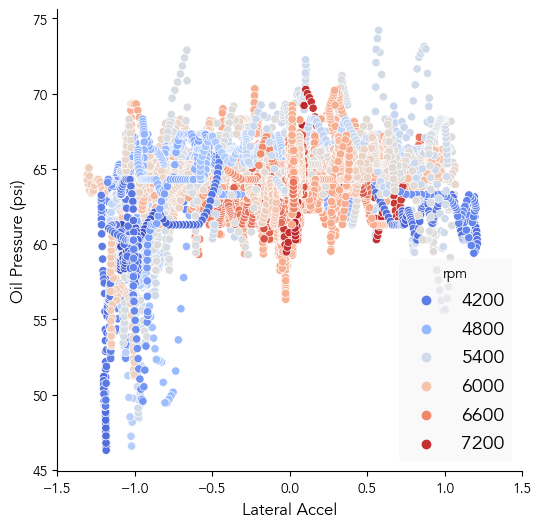

In [76]:
sns.scatterplot(x = 'lateral_acc', y = 'engine_psi_adj', data = test_data, hue = 'rpm',
                palette='coolwarm')
plt.xlim([-1.5,1.5])
plt.xlabel('Lateral Accel')
plt.ylabel('Oil Pressure (psi)')
fig.savefig(f'./vir/figures/lap_{LAP}_oil_pressure_latacc_x_rpm.png', bbox_inches='tight', facecolor='w')
pass

# GPS

In [83]:
gdf = gpd.GeoDataFrame(data = test_data,
                       geometry = gpd.points_from_xy(test_data['longitude'], test_data['latitude']))

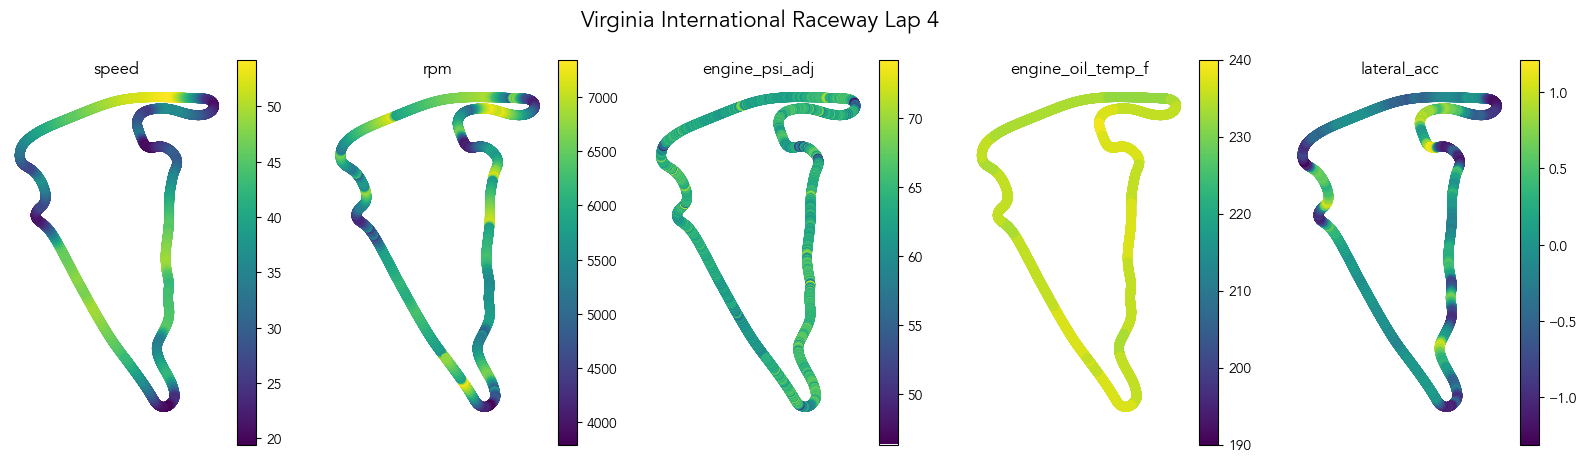

In [99]:
vars = [
    'speed', 'rpm', 'engine_psi_adj', 'engine_oil_temp_f', 
    'lateral_acc'
]


fig, ax = plt.subplots(1,5, figsize=(20,5))
axl = ax.flatten()

for idx, v in enumerate(vars):
    a = axl[idx]
    vmin = None
    vmax = None
    if v == 'engine_oil_temp_f':
        vmin=190
        vmax=240
    gdf.plot(ax = a,
             column = v,
             cmap='viridis',
             vmin=vmin,
             vmax=vmax,
             legend=True)
    a.axis('off')
    a.set_title(v)
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'Virginia International Raceway Lap {LAP}', fontsize=16)
fig.savefig(f'./vir/figures/lap_{LAP}_gps.png', bbox_inches='tight', facecolor='w')
pass

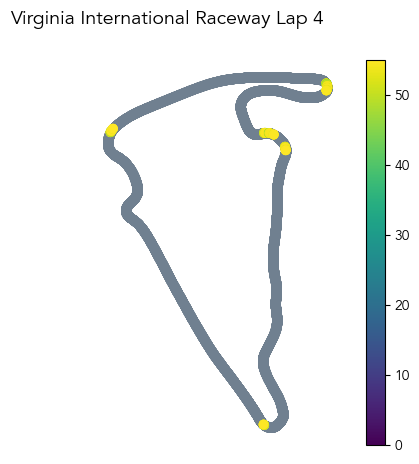

In [106]:
low = gdf.loc[gdf['engine_psi_adj']<=55]
high = gdf.loc[gdf['engine_psi_adj']>55]

fig, ax  = plt.subplots(figsize=(7,5))
high.plot(ax = ax, color = 'slategrey')
low.plot(ax = ax, column = 'engine_psi_adj', cmap='viridis', legend=True, vmin=0, vmax=55)
ax.axis('off')
fig.suptitle(f'Virginia International Raceway Lap {LAP}', fontsize=14)
fig.savefig(f'./vir/figures/lap_{LAP}_gps_low_pressure_zone.png', bbox_inches='tight', facecolor='w')
pass

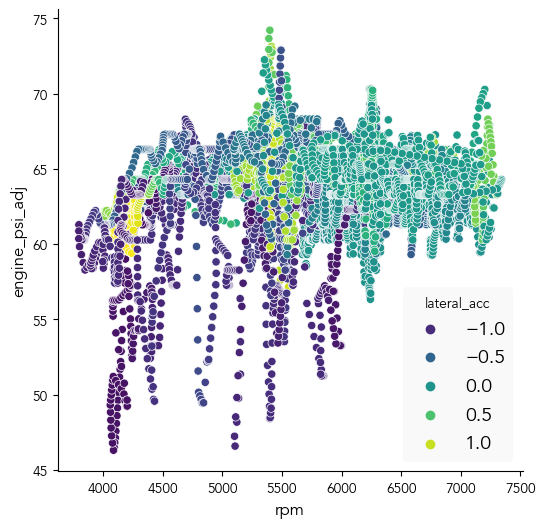

In [108]:
sns.scatterplot(x = 'rpm', y = 'engine_psi_adj', data = test_data, hue = 'lateral_acc',
               palette='viridis')
plt.savefig(f'./vir/figures/lap_{LAP}_rpm_vs_psi_x_latacc.png', facecolor='w', bbox_inches='tight')
pass